In [ ]:
%tensorflow_version 2.x
%load_ext tensorboard 

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, datasets, utils, backend, Model
import datetime
from sklearn.metrics import roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import pathlib
import time
import seaborn as sns
import numpy as np
import time
!rm -rf ./logs/

#tf.config.run_functions_eagerly(True)

In [ ]:
def img_rmse(image1, image2):
  error = np.sqrt(np.sum((image1.astype('float')-image2.astype('float'))**2))
  return error

# Load MNIST and Fashion datasets
mn = tf.keras.datasets.mnist
fs = tf.keras.datasets.fashion_mnist
(mx_train, my_train), (mx_test, my_test) = mn.load_data() # MNIST
(fx_train, fy_train), (fx_test, fy_test) = fs.load_data() # Fashion MNIST

kx_test, ky_test = tfds.as_numpy(tfds.load(
    'kmnist',
    split='test',
    batch_size=-1,
    as_supervised=True,
))



# Normalize Image values to [0,1]
mx_train = mx_train/255.0
mx_test = mx_test/255.0

fx_train = fx_train/255.0
fx_test = fx_test/255.0
kx_test = np.reshape(kx_test, [-1, 28, 28])
kx_test = kx_test/255.0


# Create Binary Labels
m_class = np.empty(len(my_test))
f_class = np.empty(len(fy_test))
k_class = np.empty(len(ky_test))

for i in range(len(my_test)):
  m_class[i]=1 # In-Distribution
  f_class[i]=0 # Out-of-Distribution
  k_class[i]=0 # Out-of-Distribution

# One Hot Encode the categories, num_classes = 10
my_train = utils.to_categorical(my_train)
my_test = utils.to_categorical(my_test)
fy_train = utils.to_categorical(fy_train)
fy_test = utils.to_categorical(fy_test)
ky_test = utils.to_categorical(ky_test)
# Get Image Dimensions, store into img_size

img_w = mx_train.shape[1]
img_h = mx_train.shape[2]

# Get Image shape and number of labels in the classifier
img_shape = (img_w, img_h, 1)
num_labels = my_train.shape[1]

# Concat individual test image/labels into one evaluation dataset
evaluation_images = np.append(fx_test, mx_test, axis=0)
evaluation_labels = np.append(fy_test, my_test, axis=0)
evaluation_images = np.append(evaluation_images, kx_test, axis=0)
evaluation_labels = np.append(evaluation_labels, ky_test, axis=0)
evaluation_class = np.append(f_class, m_class, axis=0)
evaluation_class = np.append(evaluation_class, k_class, axis=0)


ind_evaluation_images = np.reshape(evaluation_images, [-1, 28, 28, 1])

print(ind_evaluation_images.shape)

4431872/4422102 [==============================] - 0s 0us/step


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/kmnist/3.0.1.incompleteBWBR4Y/kmnist-train.tfrecord


  0%|          | 0/60000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/kmnist/3.0.1.incompleteBWBR4Y/kmnist-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset kmnist downloaded and prepared to /root/tensorflow_datasets/kmnist/3.0.1. Subsequent calls will reuse this data.
Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


(30000, 28, 28, 1)


In [ ]:
# Hyperparameters for Hybrid and Independent neural networks
input_shape = img_shape
batch_size = 64
kernel_size = (3,3)
pool_size = (2,2)
latent_dim = 64
filters = 64
dropout = .25
Epochs = 10


# Implement logs and tensorboard_callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
# Write a function to define a hybrid model
def make_hybrid_model(input_shape, filters, kernel_size, cn, gn):
  inputs = tf.keras.layers.Input(shape = input_shape, name = 'common_input')
  x = tf.keras.layers.Conv2D(filters = filters, 
                             kernel_size= kernel_size,
                             activation = 'relu',  
                             )(inputs)
  x = tf.keras.layers.Conv2D(filters = filters*2, 
                             kernel_size= kernel_size,
                             activation = 'relu',  
                             )(x)
  
  shape = tf.keras.backend.int_shape(x)
  x = tf.keras.layers.Flatten()(x)

  core = tf.keras.layers.Dense(latent_dim, name = 'waist') (x)

  # Classifier Network Sublayers
  flat = (tf.keras.layers.Flatten())(core)
  drop = (tf.keras.layers.Dropout(dropout))(flat)

  dense = (tf.keras.layers.Dense(num_labels))(drop)
  class_out = (tf.keras.layers.Activation('softmax', name = cn))(dense)

  # Autoencoder Network Sublayers
  x = tf.keras.layers.Dense(shape[1] * shape[2] * shape[3])(core)
  x = tf.keras.layers.Reshape((shape[1], shape[2], shape[3]))(x)

  x = tf.keras.layers.Conv2DTranspose(filters = filters, 
                                      kernel_size = kernel_size,
                                      activation = 'relu',  
                                      )(x)
  auto_out = tf.keras.layers.Conv2DTranspose(filters = 1, 
                                      kernel_size = kernel_size,
                                      activation = 'relu',
                                      name=gn 
                                      )(x)

  hybrid_model = tf.keras.Model(inputs = inputs,
                          outputs = [class_out, auto_out],)
  
  tf.keras.utils.plot_model(hybrid_model, to_file = 'symbiotic_nn_summary.png',
                          show_shapes = True)
  
  return hybrid_model

In [ ]:
a_hyb = make_hybrid_model(input_shape, filters, kernel_size, 
                          "Classifier-A", "Generator-A")
b_hyb = make_hybrid_model(input_shape, filters, kernel_size, 
                          "Classifier-B", "Generator-B")
c_hyb = make_hybrid_model(input_shape, filters, kernel_size, 
                          "Classifier-C", "Generator-C")
d_hyb = make_hybrid_model(input_shape, filters, kernel_size, 
                          "Classifier-D", "Generator-D")
e_hyb = make_hybrid_model(input_shape, filters, kernel_size, 
                          "Classifier-E", "Generator-E")
f_hyb = make_hybrid_model(input_shape, filters, kernel_size, 
                          "Classifier-F", "Generator-F")
g_hyb = make_hybrid_model(input_shape, filters, kernel_size, 
                          "Classifier-G", "Generator-G")
h_hyb = make_hybrid_model(input_shape, filters, kernel_size, 
                          "Classifier-H", "Generator-H")
i_hyb = make_hybrid_model(input_shape, filters, kernel_size, 
                          "Classifier-I", "Generator-I")

tf.keras.utils.plot_model(a_hyb, to_file = 'symbiotic_nn_summary.png',
                          show_shapes = True)
# 100% classifier weight, 0% generator weight
a_hyb.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=.001),
  loss={
      "Classifier-A": tf.keras.losses.categorical_crossentropy,
      "Generator-A": tf.keras.losses.MSE,
  },
  loss_weights=[1,0],
  metrics = ['accuracy']
)


# 100% classifier weight, 25% generator weight
b_hyb.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=.001),
  loss={
      "Classifier-B": tf.keras.losses.categorical_crossentropy,
      "Generator-B": tf.keras.losses.MSE,
  },
  loss_weights=[1.0,0.25],
  metrics = ['accuracy']
)

# 100% classifier weight, 50% generator weight
c_hyb.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=.001),
  loss={
      "Classifier-C": tf.keras.losses.categorical_crossentropy,
      "Generator-C": tf.keras.losses.MSE,
  },
  loss_weights=[1.0,0.5],
  metrics = ['accuracy']
)

# 100% classifier weight, 75% generator weight
d_hyb.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=.001),
  loss={
      "Classifier-D": tf.keras.losses.categorical_crossentropy,
      "Generator-D": tf.keras.losses.MSE,
  },
  loss_weights=[1.0,0.75],
  metrics = ['accuracy']
)

# 100% classifier weight, 100% generator weight
e_hyb.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=.001),
  loss={
      "Classifier-E": tf.keras.losses.categorical_crossentropy,
      "Generator-E": tf.keras.losses.MSE,
  },
  loss_weights=[1.0,1.0],
  metrics = ['accuracy']
)

# 75% classifier weight, 100% generator weight
f_hyb.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=.001),
  loss={
      "Classifier-F": tf.keras.losses.categorical_crossentropy,
      "Generator-F": tf.keras.losses.MSE,
  },
  loss_weights=[0.75,1.0],
  metrics = ['accuracy']
)

# 50% classifier weight, 100% generator weight
g_hyb.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=.001),
  loss={
      "Classifier-G": tf.keras.losses.categorical_crossentropy,
      "Generator-G": tf.keras.losses.MSE,
  },
  loss_weights=[0.50,1.0],
  metrics = ['accuracy']
)

# 25% classifier weight, 100% generator weight
h_hyb.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=.001),
  loss={
      "Classifier-H": tf.keras.losses.categorical_crossentropy,
      "Generator-H": tf.keras.losses.MSE,
  },
  loss_weights=[0.25,1.0],
  metrics = ['accuracy']
)

# 0% classifier weight, 100% generator weight
i_hyb.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=.001),
  loss={
      "Classifier-I": tf.keras.losses.categorical_crossentropy,
      "Generator-I": tf.keras.losses.MSE,
  },
  loss_weights=[0.0,1.0],
  metrics = ['accuracy']
)

In [ ]:
# Build the independent classifier and autoencoder

# Build the Convolutional Neural Network

cnn = tf.keras.models.Sequential()
# First Layers
cnn.add(tf.keras.layers.Conv2D(filters = filters, kernel_size=kernel_size,
                               activation = 'relu', 
                               input_shape = input_shape))
cnn.add(tf.keras.layers.MaxPooling2D(pool_size))
# Second Layers
cnn.add(tf.keras.layers.Conv2D(filters = filters, 
                               kernel_size = kernel_size,
                               activation = 'relu'))
cnn.add(tf.keras.layers.MaxPooling2D(pool_size))
# 3rd Layers
cnn.add(tf.keras.layers.Conv2D(filters = filters, 
                               kernel_size = kernel_size,
                               activation = 'relu'))
cnn.add(tf.keras.layers.MaxPooling2D(pool_size))

cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dropout(dropout))

cnn.add(tf.keras.layers.Dense(num_labels))
cnn.add(tf.keras.layers.Activation('softmax'))
#cnn.summary()
tf.keras.utils.plot_model (cnn, to_file = 'cnn_structure.png', 
                           show_shapes = True)
cnn.compile(loss = 'categorical_crossentropy', optimizer = 'adam',
            metrics = ['accuracy'])

################################################################################

# The Autoencoder Model

inputs = tf.keras.layers.Input(shape = input_shape, name = 'encoder_input')
x = inputs
x = tf.keras.layers.Conv2D(filters = filters, 
                            kernel_size= kernel_size,
                            activation = 'relu',  
                            )(x)
x = tf.keras.layers.Conv2D(filters = filters*2, 
                            kernel_size= kernel_size,
                            activation = 'relu',  
                            )(x)

shape = tf.keras.backend.int_shape(x)
x = tf.keras.layers.Flatten()(x)

latent = tf.keras.layers.Dense(latent_dim, name = 'latent_vector') (x)

# Build the Encoder
encoder = tf.keras.Model(inputs, latent, name = 'encoder')
# encoder.summary()

tf.keras.utils.plot_model(encoder, to_file = 'encoder_structure.png', 
                          show_shapes = True)

# Build the Decoder
latent_inputs = tf.keras.layers.Input(shape = (latent_dim, ), 
                                      name = 'decoder_input')

x = tf.keras.layers.Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = tf.keras.layers.Reshape((shape[1], shape[2], shape[3]))(x)
x = tf.keras.layers.Conv2DTranspose(filters = filters*2, 
                                      kernel_size = kernel_size,
                                      activation = 'relu',  
                                      )(x)

x = tf.keras.layers.Conv2DTranspose(filters = filters, 
                                      kernel_size = kernel_size,
                                      activation = 'relu',  
                                      )(x)

outputs = tf.keras.layers.Conv2DTranspose(filters = 1, 
                                        kernel_size = kernel_size,
                                        activation = 'sigmoid', padding = 'same',
                                        name = 'decoder_output')(x)

decoder = tf.keras.Model(latent_inputs, outputs, name = 'decoder')
#decoder.summary()

tf.keras.utils.plot_model(decoder, to_file = 'decoder.png', show_shapes = True)

# Build the Autoencoder
autoencoder = tf.keras.Model(inputs, decoder(encoder(inputs)), 
                             name = 'autoencoder')
# autoencoder.summary()
tf.keras.utils.plot_model(autoencoder, to_file = 'autoencoder_summary.png',
                          show_shapes = True)

autoencoder.compile(loss='mse', optimizer = 'adam')
################################################################################


In [ ]:
a_hyb_time = 0
b_hyb_time = 0
c_hyb_time = 0
d_hyb_time = 0
e_hyb_time = 0
f_hyb_time = 0
g_hyb_time = 0
h_hyb_time = 0
i_hyb_time = 0
independent_time = 0

# Train the hybrid neural networks on the Fashion MNIST Data
# Hybrid A
start = time.time()
a_hyb.fit(mx_train, 
          {"Classifier-A" : my_train, "Generator-A": mx_train},
          epochs = Epochs,
          batch_size = batch_size,
          callbacks=[tb_cb],)
stop = time.time()
a_hyb_time = stop-start

# Hybrid B
start = time.time()
b_hyb.fit(mx_train, 
          {"Classifier-B" : my_train, "Generator-B": mx_train},
          epochs = Epochs,
          batch_size = batch_size,
          callbacks=[tb_cb],)
stop = time.time()
b_hyb_time = stop-start

# Hybrid C
start = time.time()
c_hyb.fit(mx_train, 
          {"Classifier-C" : my_train, "Generator-C": mx_train},
          epochs = Epochs,
          batch_size = batch_size,
          callbacks=[tb_cb],)
stop = time.time()
c_hyb_time = stop-start

# Hybrid D
start = time.time()
d_hyb.fit(mx_train, 
          {"Classifier-D" : my_train, "Generator-D": mx_train},
          epochs = Epochs,
          batch_size = batch_size,
          callbacks=[tb_cb],)
stop = time.time()
d_hyb_time = stop-start

# Hybrid E
start = time.time()
e_hyb.fit(mx_train, 
          {"Classifier-E" : my_train, "Generator-E": mx_train},
          epochs = Epochs,
          batch_size = batch_size,
          callbacks=[tb_cb],)
stop = time.time()
e_hyb_time = stop-start

# Hybrid F
start = time.time()
f_hyb.fit(mx_train, 
          {"Classifier-F" : my_train, 
           "Generator-F": mx_train},
          epochs = Epochs,
          batch_size = batch_size,
          callbacks=[tb_cb],)
stop = time.time()
f_hyb_time = stop-start


# Hybrid G
start = time.time()
g_hyb.fit(mx_train, 
          {"Classifier-G" : my_train, "Generator-G": mx_train},
          epochs = Epochs,
          batch_size = batch_size,
          callbacks=[tb_cb],)
stop = time.time()
g_hyb_time = stop-start

# Hybrid H
start = time.time()
h_hyb.fit(mx_train, 
          {"Classifier-H" : my_train, "Generator-H": mx_train},
          epochs = Epochs,
          batch_size = batch_size,
          callbacks=[tb_cb],)
stop = time.time()
h_hyb_time = stop-start

# Hybrid I
start = time.time()
i_hyb.fit(mx_train, 
          {"Classifier-I" : my_train, "Generator-I": mx_train},
          epochs = Epochs,
          batch_size = batch_size,
          callbacks=[tb_cb],)
stop = time.time()
i_hyb_time = stop-start




Epoch 1/10
938/938 [==============================] - 32s 16ms/step - loss: 0.1353 - Classifier-A_loss: 0.1353 - Generator-A_loss: 0.1099 - Classifier-A_accuracy: 0.9593 - Generator-A_accuracy: 0.8088
Epoch 2/10
938/938 [==============================] - 14s 15ms/step - loss: 0.0491 - Classifier-A_loss: 0.0491 - Generator-A_loss: 0.1096 - Classifier-A_accuracy: 0.9848 - Generator-A_accuracy: 0.8088
Epoch 3/10
938/938 [==============================] - 14s 15ms/step - loss: 0.0308 - Classifier-A_loss: 0.0308 - Generator-A_loss: 0.1094 - Classifier-A_accuracy: 0.9903 - Generator-A_accuracy: 0.8088
Epoch 4/10
938/938 [==============================] - 14s 15ms/step - loss: 0.0231 - Classifier-A_loss: 0.0231 - Generator-A_loss: 0.1092 - Classifier-A_accuracy: 0.9922 - Generator-A_accuracy: 0.8088
Epoch 5/10
938/938 [==============================] - 14s 15ms/step - loss: 0.0163 - Classifier-A_loss: 0.0163 - Generator-A_loss: 0.1091 - Classifier-A_accuracy: 0.9945 - Generator-A_accuracy: 0.

In [ ]:
independent_time = 0
# reshape the datsets to accomodate the independent networks, renamed
mxr = np.reshape(mx_train, [-1, 28, 28, 1])


start = time.time()
cnn.fit(mxr, my_train, epochs = Epochs, batch_size = batch_size,)
autoencoder.fit(mxr, mxr, epochs = Epochs, batch_size = batch_size)
stop = time.time()
independent_time = stop - start

Epoch 1/10
938/938 [==============================] - 5s 4ms/step - loss: 0.3348 - accuracy: 0.8970
Epoch 2/10
938/938 [==============================] - 4s 4ms/step - loss: 0.1193 - accuracy: 0.9643
Epoch 3/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0882 - accuracy: 0.9733
Epoch 4/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0722 - accuracy: 0.9790
Epoch 5/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0606 - accuracy: 0.9817
Epoch 6/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0522 - accuracy: 0.9840
Epoch 7/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0462 - accuracy: 0.9862
Epoch 8/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0429 - accuracy: 0.9869
Epoch 9/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0374 - accuracy: 0.9880
Epoch 10/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0318 - accuracy: 0.9898

In [ ]:
print("A Hybrid Training Time: ", a_hyb_time)
print("B Hybrid Training Time: ", b_hyb_time)
print("C Hybrid Training Time: ", c_hyb_time)
print("D Hybrid Training Time: ", d_hyb_time)
print("E Hybrid Training Time: ", e_hyb_time)
print("F Hybrid Training Time: ", f_hyb_time)
print("G Hybrid Training Time: ", g_hyb_time)
print("H Hybrid Training Time: ", h_hyb_time)
print("I Hybrid Training Time: ", i_hyb_time)
print("Independent Training Time: ", independent_time)

A Hybrid Training Time:  171.19358372688293
B Hybrid Training Time:  203.00094151496887
C Hybrid Training Time:  155.9860119819641
D Hybrid Training Time:  202.99009370803833
E Hybrid Training Time:  156.49832153320312
F Hybrid Training Time:  156.79723501205444
G Hybrid Training Time:  202.96691823005676
H Hybrid Training Time:  203.00404524803162
I Hybrid Training Time:  157.82757759094238
Independent Training Time:  233.31099224090576


In [ ]:
a_hyb_time = 0
b_hyb_time = 0
c_hyb_time = 0
d_hyb_time = 0
e_hyb_time = 0
f_hyb_time = 0
g_hyb_time = 0
h_hyb_time = 0
i_hyb_time = 0
independent_time = 0


# Evaluate The Networks

# Hybrid A
start=time.time()
[a_lab, a_img] = a_hyb.predict(evaluation_images)
stop=time.time()
a_hyb_time = stop-start

# Hybrid B
start=time.time()
[b_lab, b_img] = b_hyb.predict(evaluation_images)
stop=time.time()
b_hyb_time = stop-start

# Hybrid C
start=time.time()
[c_lab, c_img] = c_hyb.predict(evaluation_images)
stop=time.time()
c_hyb_time = stop-start

# Hybrid D
start=time.time()
[d_lab, d_img] = d_hyb.predict(evaluation_images)
stop=time.time()
d_hyb_time = stop-start


# Hybrid E
start=time.time()
[e_lab, e_img] = e_hyb.predict(evaluation_images)
stop=time.time()
e_hyb_time = stop-start

# Hybrid F
start=time.time()
[f_lab, f_img] = f_hyb.predict(evaluation_images)
stop=time.time()
f_hyb_time = stop-start

# Hybrid G
start=time.time()
[g_lab, g_img] = g_hyb.predict(evaluation_images)
stop=time.time()
g_hyb_time = stop-start

# Hybrid H
start=time.time()
[h_lab, h_img] = h_hyb.predict(evaluation_images)
stop=time.time()
h_hyb_time = stop-start

# Hybrid I
start=time.time()
[i_lab, i_img] = i_hyb.predict(evaluation_images)
stop=time.time()
i_hyb_time = stop-start

# independent
start=time.time()
ind_img = autoencoder.predict(ind_evaluation_images)
ind_lab = cnn.predict(ind_evaluation_images)
stop=time.time()
independent_time = stop-start

In [ ]:
print("A Hybrid Evaluation Time: ", a_hyb_time)
print("B Hybrid Evaluation Time: ", b_hyb_time)
print("C Hybrid Evaluation Time: ", c_hyb_time)
print("D Hybrid Evaluation Time: ", d_hyb_time)
print("E Hybrid Evaluation Time: ", e_hyb_time)
print("F Hybrid Evaluation Time: ", f_hyb_time)
print("G Hybrid Evaluation Time: ", g_hyb_time)
print("H Hybrid Evaluation Time: ", h_hyb_time)
print("I Hybrid Evaluation Time: ", i_hyb_time)
print("Independent Evaluation Time: ", independent_time)

A Hybrid Evaluation Time:  2.68090558052063
B Hybrid Evaluation Time:  2.3358821868896484
C Hybrid Evaluation Time:  2.3416202068328857
D Hybrid Evaluation Time:  2.7292613983154297
E Hybrid Evaluation Time:  2.7185752391815186
F Hybrid Evaluation Time:  2.7207562923431396
G Hybrid Evaluation Time:  2.329301357269287
H Hybrid Evaluation Time:  2.311790943145752
I Hybrid Evaluation Time:  2.7115135192871094
Independent Evaluation Time:  4.50090765953064


In [ ]:
def create_roc(real_labels, predicted_labels, num_classes):
  
  fpr, tpr = dict(), dict()
  for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(real_labels[:,i], predicted_labels[:,i])

  fpr['macro'], tpr['macro'], _ = roc_curve(real_labels.ravel(), 
                                            predicted_labels.ravel())

  return fpr, tpr 
  

a_fpr, a_tpr = create_roc(evaluation_labels, a_lab, 10) 
b_fpr, b_tpr = create_roc(evaluation_labels, b_lab, 10) 
c_fpr, c_tpr = create_roc(evaluation_labels, c_lab, 10) 
d_fpr, d_tpr = create_roc(evaluation_labels, d_lab, 10) 
e_fpr, e_tpr = create_roc(evaluation_labels, e_lab, 10) 
f_fpr, f_tpr = create_roc(evaluation_labels, f_lab, 10) 
g_fpr, g_tpr = create_roc(evaluation_labels, g_lab, 10) 
h_fpr, h_tpr = create_roc(evaluation_labels, h_lab, 10) 
i_fpr, i_tpr = create_roc(evaluation_labels, i_lab, 10) 
ind_fpr, ind_tpr = create_roc(evaluation_labels, ind_lab, 10) 

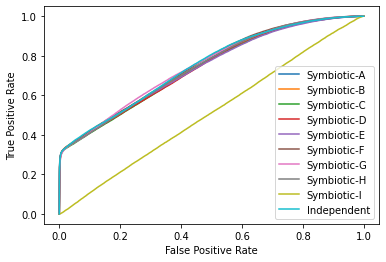

In [ ]:
# Plot Unguarded ROC curves
plt.figure()

plt.plot(a_fpr['macro'], a_tpr['macro'], label='Symbiotic-A')
plt.plot(b_fpr['macro'], b_tpr['macro'], label='Symbiotic-B')
plt.plot(c_fpr['macro'], c_tpr['macro'], label='Symbiotic-C')
plt.plot(d_fpr['macro'], d_tpr['macro'], label='Symbiotic-D')
plt.plot(e_fpr['macro'], e_tpr['macro'], label='Symbiotic-E')
plt.plot(f_fpr['macro'], f_tpr['macro'], label='Symbiotic-F')
plt.plot(g_fpr['macro'], g_tpr['macro'], label='Symbiotic-G')
plt.plot(h_fpr['macro'], h_tpr['macro'], label='Symbiotic-H')
plt.plot(i_fpr['macro'], i_tpr['macro'], label='Symbiotic-I')
plt.plot(ind_fpr['macro'], ind_tpr['macro'], label='Independent')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.show()

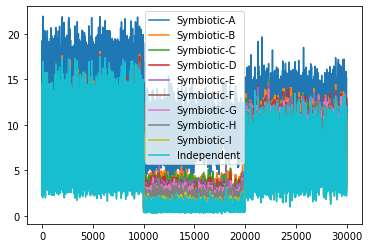

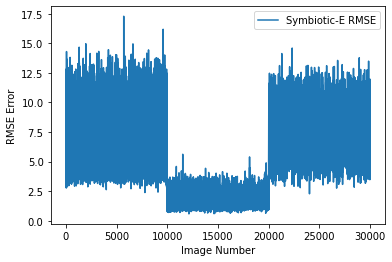

In [ ]:
def calculate_rmse_results(regenerated_images, original_images):
  rmse_values = np.empty(len(evaluation_labels))
  for i in range(len(regenerated_images)):
    rmse_values[i] = img_rmse(regenerated_images[i], original_images[i])

  return rmse_values


a_rmse=calculate_rmse_results(np.squeeze(a_img), evaluation_images)
b_rmse=calculate_rmse_results(np.squeeze(b_img), evaluation_images)
c_rmse=calculate_rmse_results(np.squeeze(c_img), evaluation_images)
d_rmse=calculate_rmse_results(np.squeeze(d_img), evaluation_images)
e_rmse=calculate_rmse_results(np.squeeze(e_img), evaluation_images)
f_rmse=calculate_rmse_results(np.squeeze(f_img), evaluation_images)
g_rmse=calculate_rmse_results(np.squeeze(g_img), evaluation_images)
h_rmse=calculate_rmse_results(np.squeeze(h_img), evaluation_images)
i_rmse=calculate_rmse_results(np.squeeze(i_img), evaluation_images)
ind_rmse=calculate_rmse_results(np.squeeze(ind_img), 
                                np.squeeze(ind_evaluation_images))

plt.figure()
plt.plot(a_rmse, label='Symbiotic-A')
plt.plot(b_rmse, label='Symbiotic-B')
plt.plot(c_rmse, label='Symbiotic-C')
plt.plot(d_rmse, label='Symbiotic-D')
plt.plot(e_rmse, label='Symbiotic-E')
plt.plot(f_rmse, label='Symbiotic-F')
plt.plot(g_rmse, label='Symbiotic-G')
plt.plot(h_rmse, label='Symbiotic-H')
plt.plot(i_rmse, label='Symbiotic-I')
plt.plot(ind_rmse, label='Independent')
plt.legend()
plt.show()

plt.figure()
plt.plot(e_rmse, label='Symbiotic-E RMSE')
plt.xlabel('Image Number')
plt.ylabel('RMSE Error')
plt.legend()
plt.show()


TypeError: ignored

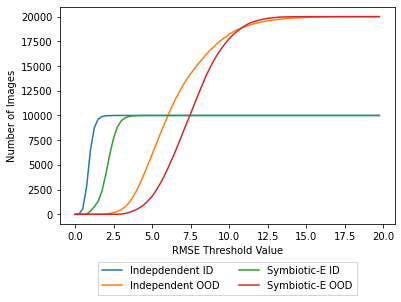

In [ ]:
def get_img_breakdown(rmse_values):
  good,bad,thr = np.empty(80), np.empty(80), np.empty(80)
  good_imgs=0 # image counts
  bad_imgs=0 # image counts
  for j in range(80):
    good_imgs=0
    bad_imgs=0
    threshold = j/4
    for i in range(len(rmse_values)):
      if rmse_values[i] < threshold:
        if evaluation_class[i]==1:
          good_imgs+=1
        else:
          bad_imgs+=1

    good[j]=(good_imgs)
    bad[j]=(bad_imgs)
    thr[j]=(threshold)

  return good, bad, thr


a_good, a_bad, thr = get_img_breakdown(a_rmse)
b_good, b_bad, _ = get_img_breakdown(b_rmse)
c_good, c_bad, _ = get_img_breakdown(c_rmse)
d_good, d_bad, _ = get_img_breakdown(d_rmse)
e_good, e_bad, _ = get_img_breakdown(e_rmse)
f_good, f_bad, _ = get_img_breakdown(f_rmse)
g_good, g_bad, _ = get_img_breakdown(g_rmse)
h_good, h_bad, _ = get_img_breakdown(h_rmse)
i_good, i_bad, _ = get_img_breakdown(i_rmse)
ind_good, ind_bad, _ = get_img_breakdown(ind_rmse)


plt.figure()
plt.plot(thr, ind_good, label='Indepdendent ID')
plt.plot(thr, ind_bad, label='Independent OOD')
plt.plot(thr, e_good, label='Symbiotic-E ID')
plt.plot(thr, e_bad, label='Symbiotic-E OOD')
plt.xlabel('RMSE Threshold Value')
plt.ylabel('Number of Images')
plt.legend(plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
           fancybox=False, shadow=False, ncol=2))
plt.show()

In [ ]:
# mx_test my_test
a_pred, _ = a_hyb.predict(mx_test)
b_pred, _ = b_hyb.predict(mx_test)
c_pred, _ = c_hyb.predict(mx_test)
d_pred, _ = d_hyb.predict(mx_test)
e_pred, _ = e_hyb.predict(mx_test)
f_pred, _ = f_hyb.predict(mx_test)
g_pred, _ = g_hyb.predict(mx_test)
h_pred, _ = h_hyb.predict(mx_test)
i_pred, _ = i_hyb.predict(mx_test)

ind_tst = np.reshape(mx_test, [-1, 28, 28, 1])
ind_pred = cnn.predict(ind_tst)

a_fpr_in, a_tpr_in = create_roc(my_test, a_pred, 10)
b_fpr_in, b_tpr_in = create_roc(my_test, b_pred, 10)
c_fpr_in, c_tpr_in = create_roc(my_test, c_pred, 10)
d_fpr_in, d_tpr_in = create_roc(my_test, d_pred, 10)
e_fpr_in, e_tpr_in = create_roc(my_test, e_pred, 10)
f_fpr_in, f_tpr_in = create_roc(my_test, f_pred, 10)
g_fpr_in, g_tpr_in = create_roc(my_test, g_pred, 10)
h_fpr_in, h_tpr_in = create_roc(my_test, h_pred, 10)
i_fpr_in, i_tpr_in = create_roc(my_test, i_pred, 10)
ind_fpr_in, ind_tpr_in = create_roc(my_test, ind_pred, 10)

plt.figure()
plt.plot(a_fpr_in['macro'], a_tpr_in['macro'], label='Symbiotic-A')
plt.plot(b_fpr_in['macro'], b_tpr_in['macro'], label='Symbiotic-B')
plt.plot(c_fpr_in['macro'], c_tpr_in['macro'], label='Symbiotic-C')
plt.plot(d_fpr_in['macro'], d_tpr_in['macro'], label='Symbiotic-D')
plt.plot(e_fpr_in['macro'], e_tpr_in['macro'], label='Symbiotic-E')
plt.plot(f_fpr_in['macro'], f_tpr_in['macro'], label='Symbiotic-F')
plt.plot(g_fpr_in['macro'], g_tpr_in['macro'], label='Symbiotic-G')
plt.plot(h_fpr_in['macro'], h_tpr_in['macro'], label='Symbiotic-H')
plt.plot(i_fpr_in['macro'], i_tpr_in['macro'], label='Symbiotic-I')
plt.plot(ind_fpr_in['macro'], ind_tpr_in['macro'], label='Independent')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.figure()
plt.plot(a_fpr_in['macro'], a_tpr_in['macro'], label='Symbiotic-A')
plt.plot(b_fpr_in['macro'], b_tpr_in['macro'], label='Symbiotic-B')
plt.plot(c_fpr_in['macro'], c_tpr_in['macro'], label='Symbiotic-C')
plt.plot(d_fpr_in['macro'], d_tpr_in['macro'], label='Symbiotic-D')
plt.plot(e_fpr_in['macro'], e_tpr_in['macro'], label='Symbiotic-E')
plt.plot(f_fpr_in['macro'], f_tpr_in['macro'], label='Symbiotic-F')
plt.plot(g_fpr_in['macro'], g_tpr_in['macro'], label='Symbiotic-G')
plt.plot(h_fpr_in['macro'], h_tpr_in['macro'], label='Symbiotic-H')
plt.plot(i_fpr_in['macro'], i_tpr_in['macro'], label='Symbiotic-I')
plt.plot(ind_fpr_in['macro'], ind_tpr_in['macro'], label='Independent')
plt.xlim([-.01, .2])
plt.ylim([.85, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
           fancybox=False, shadow=False, ncol=3))

In [ ]:
def guard_eval(gen, label, threshold):

  img = []
  lab = []
  pred = []
  for i in range(len(evaluation_labels)):
    real = evaluation_images[i]
    regen = np.squeeze(gen[i])
  
    if img_rmse(real, regen) < threshold:
      img.append(a_img[i])
      lab.append(evaluation_labels[i])
      pred.append(a_label[i])

  img=np.array(img)
  lab=np.array(lab)
  pred=np.array(pred)

  return img, lab, pred

In [ ]:
_, a35_labels, a35_preds = guard_eval(a_img, a_lab, 3.5)
_, a4_labels, a4_preds = guard_eval(a_img, a_lab, 4)
_, a45_labels, a45_preds = guard_eval(a_img, a_lab, 4.5)


_, b35_labels, b35_preds = guard_eval(b_img, b_lab, 3.5)
_, b4_labels, b4_preds = guard_eval(b_img, b_lab, 4)
_, b45_labels, b45_preds = guard_eval(b_img, b_lab, 4.5)


_, c35_labels, c35_preds = guard_eval(c_img, c_lab, 3.5)
_, c4_labels, c4_preds = guard_eval(c_img, c_lab, 4)
_, c45_labels, c45_preds = guard_eval(c_img, c_lab, 4.5)


_, d35_labels, d35_preds = guard_eval(d_img, d_lab, 3.5)
_, d4_labels, d4_preds = guard_eval(d_img, d_lab, 4)
_, d45_labels, d45_preds = guard_eval(d_img, d_lab, 4.5)


_, e35_labels, e35_preds = guard_eval(e_img, e_lab, 3.5)
_, e4_labels, e4_preds = guard_eval(e_img, e_lab, 4)
_, e45_labels, e45_preds = guard_eval(e_img, e_lab, 4.5)


_, f35_labels, f35_preds = guard_eval(f_img, f_lab, 3.5)
_, f4_labels, f4_preds = guard_eval(f_img, f_lab, 4)
_, f45_labels, f45_preds = guard_eval(f_img, f_lab, 4.5)


_, g35_labels, g35_preds = guard_eval(g_img, g_lab, 3.5)
_, g4_labels, g4_preds = guard_eval(g_img, g_lab, 4)
_, g45_labels, g45_preds = guard_eval(g_img, g_lab, 4.5)


_, h35_labels, h35_preds = guard_eval(h_img, h_lab, 3.5)
_, h4_labels, h4_preds = guard_eval(h_img, h_lab, 4)
_, h45_labels, h45_preds = guard_eval(h_img, h_lab, 4.5)


_, i35_labels, i35_preds = guard_eval(i_img, i_lab, 3.5)
_, i4_labels, i4_preds = guard_eval(i_img, i_lab, 4)
_, i45_labels, i45_preds = guard_eval(i_img, i_lab, 4.5)


_, ind35_labels, ind35_preds = guard_eval(ind_img, ind_lab, 3.5)
_, ind4_labels, ind4_preds = guard_eval(ind_img, ind_lab, 4)
_, ind45_labels, ind45_preds = guard_eval(ind_img, ind_lab, 4.5)





In [ ]:
a35_fpr, a35_tpr = create_roc(a35_labels, a35_preds, 10)
a4_fpr, a4_tpr = create_roc(a4_labels, a4_preds, 10)
a45_fpr, a45_tpr = create_roc(a45_labels, a45_preds, 10)

b35_fpr, b35_tpr = create_roc(b35_labels, b35_preds, 10)
b4_fpr, b4_tpr = create_roc(b4_labels, b4_preds, 10)
b45_fpr, b45_tpr = create_roc(b45_labels, b45_preds, 10)

c35_fpr, c35_tpr = create_roc(c35_labels, c35_preds, 10)
c4_fpr, c4_tpr = create_roc(c4_labels, c4_preds, 10)
c45_fpr, c45_tpr = create_roc(c45_labels, c45_preds, 10)

d35_fpr, d35_tpr = create_roc(d35_labels, d35_preds, 10)
d4_fpr, d4_tpr = create_roc(d4_labels, d4_preds, 10)
d45_fpr, d45_tpr = create_roc(d45_labels, d45_preds, 10)

e35_fpr, e35_tpr = create_roc(e35_labels, e35_preds, 10)
e4_fpr, e4_tpr = create_roc(e4_labels, e4_preds, 10)
e45_fpr, e45_tpr = create_roc(e45_labels, e45_preds, 10)

f35_fpr, f35_tpr = create_roc(f35_labels, f35_preds, 10)
f4_fpr, f4_tpr = create_roc(f4_labels, f4_preds, 10)
f45_fpr, f45_tpr = create_roc(f45_labels, f45_preds, 10)

g35_fpr, g35_tpr = create_roc(g35_labels, g35_preds, 10)
g4_fpr, g4_tpr = create_roc(g4_labels, g4_preds, 10)
g45_fpr, g45_tpr = create_roc(g45_labels, g45_preds, 10)

h35_fpr, h35_tpr = create_roc(h35_labels, h35_preds, 10)
h4_fpr, h4_tpr = create_roc(h4_labels, h4_preds, 10)
h45_fpr, h45_tpr = create_roc(h45_labels, h45_preds, 10)

i35_fpr, i35_tpr = create_roc(i35_labels, i35_preds, 10)
i4_fpr, i4_tpr = create_roc(i4_labels, i4_preds, 10)
i45_fpr, i45_tpr = create_roc(i45_labels, i45_preds, 10)

ind35_fpr, ind35_tpr = create_roc(ind35_labels, ind35_preds, 10)
ind4_fpr, ind4_tpr = create_roc(ind4_labels, ind4_preds, 10)
ind45_fpr, ind45_tpr = create_roc(ind45_labels, ind45_preds, 10)



plt.figure()
plt.plot(a35_fpr['macro'], a35_tpr['macro'], label='Symbiotic-A')
plt.plot(b35_fpr['macro'], b35_tpr['macro'], label='Symbiotic-B')
plt.plot(c35_fpr['macro'], c35_tpr['macro'], label='Symbiotic-C')
plt.plot(d35_fpr['macro'], d35_tpr['macro'], label='Symbiotic-D')
plt.plot(e35_fpr['macro'], e35_tpr['macro'], label='Symbiotic-E')
plt.plot(f35_fpr['macro'], f35_tpr['macro'], label='Symbiotic-F')
plt.plot(g35_fpr['macro'], g35_tpr['macro'], label='Symbiotic-G')
plt.plot(h35_fpr['macro'], h35_tpr['macro'], label='Symbiotic-H')
#plt.plot(i35_fpr['macro'], i35_tpr['macro'], label='Symbiotic-I')
plt.plot(ind35_fpr['macro'], ind35_tpr['macro'], label='Independent')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
           fancybox=False, shadow=False, ncol=2))



plt.figure()
plt.plot(a4_fpr['macro'], a4_tpr['macro'], label='Symbiotic-A')
plt.plot(b4_fpr['macro'], b4_tpr['macro'], label='Symbiotic-B')
plt.plot(c4_fpr['macro'], c4_tpr['macro'], label='Symbiotic-C')
plt.plot(d4_fpr['macro'], d4_tpr['macro'], label='Symbiotic-D')
plt.plot(e4_fpr['macro'], e4_tpr['macro'], label='Symbiotic-E')
plt.plot(f4_fpr['macro'], f4_tpr['macro'], label='Symbiotic-F')
plt.plot(g4_fpr['macro'], g4_tpr['macro'], label='Symbiotic-G')
plt.plot(h4_fpr['macro'], h4_tpr['macro'], label='Symbiotic-H')
#plt.plot(i4_fpr['macro'], i4_tpr['macro'], label='Symbiotic-I')
plt.plot(ind4_fpr['macro'], ind4_tpr['macro'], label='Independent')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
           fancybox=False, shadow=False, ncol=2))


plt.figure()
plt.plot(a45_fpr['macro'], a45_tpr['macro'], label='Symbiotic-A')
plt.plot(b45_fpr['macro'], b45_tpr['macro'], label='Symbiotic-B')
plt.plot(c45_fpr['macro'], c45_tpr['macro'], label='Symbiotic-C')
plt.plot(d45_fpr['macro'], d45_tpr['macro'], label='Symbiotic-D')
plt.plot(e45_fpr['macro'], e45_tpr['macro'], label='Symbiotic-E')
plt.plot(f45_fpr['macro'], f45_tpr['macro'], label='Symbiotic-F')
plt.plot(g45_fpr['macro'], g45_tpr['macro'], label='Symbiotic-G')
plt.plot(h45_fpr['macro'], h45_tpr['macro'], label='Symbiotic-H')
#plt.plot(i45_fpr['macro'], i45_tpr['macro'], label='Symbiotic-I')
plt.plot(ind45_fpr['macro'], ind45_tpr['macro'], label='Independent')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
           fancybox=False, shadow=False, ncol=2))

In [ ]:
def plot_imgs(index):

  plt.figure(figsize=(13,4))
  plt.subplot(2,5,1)
  plt.imshow(evaluation_images[index], cmap='gray')
  plt.subplot(2,5,2)
  plt.imshow(np.squeeze(a_img[index]), cmap='gray')
  plt.subplot(2,5,3)
  plt.imshow(np.squeeze(b_img[index]), cmap='gray')
  plt.subplot(2,5,4)
  plt.imshow(np.squeeze(c_img[index]), cmap='gray')
  plt.subplot(2,5,5)
  plt.imshow(np.squeeze(d_img[index]), cmap='gray')
  plt.subplot(2,5,6)
  plt.imshow(np.squeeze(e_img[index]), cmap='gray')
  plt.subplot(2,5,7)
  plt.imshow(np.squeeze(f_img[index]), cmap='gray')
  plt.subplot(2,5,8)
  plt.imshow(np.squeeze(g_img[index]), cmap='gray')
  plt.subplot(2,5,9)
  plt.imshow(np.squeeze(h_img[index]), cmap='gray')
  plt.subplot(2,5,10)
  plt.imshow(np.squeeze(i_img[index]), cmap='gray')
  plt.show(plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
           fancybox=False, shadow=False, ncol=2))

In [ ]:
plot_imgs(10)

plot_imgs(12740)

plot_imgs(24470)